<a href="https://colab.research.google.com/github/ringerH/NLP/blob/main/Fine_tuning_BERT(multilabel_text_classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [5]:
!pip install -Uqr models/official/requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.6/219.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 98.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 116.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 113.8 MB/s eta 0:

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [15]:
df=pd.read_csv('CleanedData.csv')

In [16]:
df.shape

(40188, 2)

In [9]:
df.tail(102)

,subject,transformed text
2805,1,trump alli expect us dismiss dossier detail do...
2806,1,msnbc host joy reid shock conserv activist ope...
2807,1,donald trump ban muslim emigr unit state neg e...
2808,1,chao across nation port entri today inde world...
2809,1,donald trump war scienc draw respons scienc gu...
...,...,...
2902,1,ever need know exactli divis donald trump ever...
2903,1,even fox news know donald trump administr make...
2904,1,donald trump inaugur one disappoint american h...
2905,1,sunday morn donald trump take twitter whine cr...


<Axes: title={'center': 'Subject distro'}, ylabel='Frequency'>

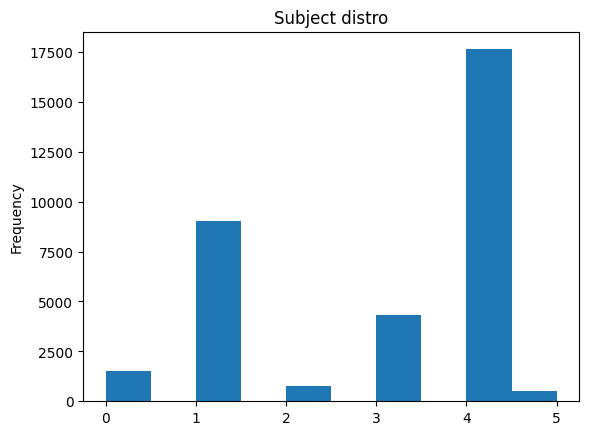

In [12]:
df.subject.plot(kind='hist', title='Subject distro')

In [14]:
train_df, valid_df = train_test_split(df, random_state=42, train_size=0.8, test_size=0.2)
train_df.shape, valid_df.shape

((27032, 2), (6758, 2))

**MOST IMPORTANT STEP**

The tf.data API here helps us build this flexible and efficient input pipeline.
As during training, many input elements need to be pre-processed. We need to convert this to a format of **token IDs, input mask IDs and input type IDs** so that, BERT can accept it as input. Since many input elements will have to be processed, the tf.data offers the **tf.data.Dataset.map transformation, which applies a user defined function to each element of the input data set**.
And because the input elements are independent to one another, the pre-processing step can be parallelised across multiple CPU course.
To make this possible, **the map transformation from the tf.data API provides an argument where we can specify the level of parallelism that we want during pre-processing.**
So we can do all the pre-processing step on the CPU, and that way there's no CPU or GPU overhead.



**Creating a Python object to attain iterability for usage in loops**

To construct a data set, from data in memory, we use the tf.data.Dataset
from **tensor method or the tf.data.Dataset from tensor slices method** and the return dataset is  a Python object which is iterable, which makes it possible to consume its elements using a for loop.

**ESSENTIALLY**

The dataset needs to be converted to a Python object to attain iterability(for obvious reasons) :)


In [1]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['transformed text'].values, train_df['subject'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['transformed text'].values, valid_df['subject'].values))

NameError: ignored